## AST4310, Autumn 2021, Project 1

Authored by (candidate number): ***15508***.

#### Header and imports

In [1]:
import numpy
import matplotlib.pyplot as plt
from astropy import units
from astropy import constants

%matplotlib inline

from matplotlib import cm
from astropy.visualization import quantity_support
quantity_support()

plt.rc("legend", frameon=False)
plt.rc("figure", figsize=(7, 7/1.3))
plt.rc("font", size=12)

In [2]:
class Atom: # sent to students from group teacher, all functions included
    """
    Reads atomic data, calculates level populations according to Boltzmann's law,
    and ionisation fractions according to Saha's law.
    """
    
    def __init__(self, atomfile=None):
        """
        Parameters
        ----------
        atomfile : string, optional
            Name of file with atomic data. If not present, atomic data needs
            to be loaded with the .read_atom method.
        """
        self.loaded = False
        if atomfile:
            self.read_atom(atomfile)
        
    def read_atom(self, filename):
        """
        Reads atom structure from text file.
        
        Parameters
        ----------
        filename: string
            Name of file with atomic data.
        """
        tmp = numpy.loadtxt(filename, unpack=True)
        self.n_stages = int(tmp[2].max()) + 1
        # Get maximum number of levels in any stage
        self.max_levels = 0
        for i in range(self.n_stages):
            self.max_levels = max(self.max_levels, (tmp[2] == i).sum())
        # Populate level energies and statistical weights
        # Use a square array filled with NaNs for non-existing levels
        chi = numpy.empty((self.n_stages, self.max_levels))
        chi.fill(numpy.nan)
        self.g = numpy.copy(chi)
        for i in range(self.n_stages):
            nlevels = (tmp[2] == i).sum()
            chi[i, :nlevels] = tmp[0][tmp[2] == i]
            self.g[i, :nlevels] = tmp[1][tmp[2] == i]
        # Put units, convert from cm-1 to Joule
        chi = (chi / units.cm).to('aJ', equivalencies=units.spectral())
        # Save ionisation energies, saved as energy of first level in each stage
        self.chi_ion = chi[:, 0].copy()
        # Save level energies relative to ground level in each stage
        self.chi = chi - self.chi_ion[:, numpy.newaxis]
        self.loaded = True
        
    def compute_partition_function(self, temperature):
        """
        Computes partition functions using the atomic level energies and
        statistical weights.
        
        Parameters
        ----------
        temperature: astropy.units.quantity (scalar or array)
            Gas temperature in units of K or equivalent.
        """
        if not self.loaded:
            raise ValueError("Missing atom structure, please load atom with read_atom()")
        temp = temperature[numpy.newaxis, numpy.newaxis]  # to allow broadcast
        return numpy.nansum(self.g[..., numpy.newaxis] * 
                            numpy.exp(-self.chi[..., numpy.newaxis] / 
                                      constants.k_B / temp), axis=1)
    
    def compute_excitation(self, temperature):
        """
        Computes the level populations relative to the ground state,
        according to the Boltzmann law.
        
        Parameters
        ----------
        temperature: astropy.units.quantity (scalar or array)
            Gas temperature in units of K or equivalent.
        """
        pfunc = self.compute_partition_function(temperature)
        # Reshape arrays to allow broadcast
        temp = temperature[numpy.newaxis, numpy.newaxis]
        g_ratio = self.g[..., numpy.newaxis] / pfunc[:, numpy.newaxis]  # relative to total number of atoms in this stage
        chi = self.chi[..., numpy.newaxis]
        return g_ratio * numpy.exp(-chi / (constants.k_B * temp))
       
    def compute_ionisation(self, temperature, electron_pressure):
        """
        Computes ionisation fractions according to the Saha law.
        
        Parameters
        ----------
        temperature: astropy.units.quantity (scalar or array)
            Gas temperature in units of K or equivalent.
        electron_pressure: astropy.units.quantity (scalar)
            Electron pressure in units of Pa or equivalent.
        """
        partition_function = self.compute_partition_function(temperature)
        electron_density = electron_pressure / (constants.k_B * temperature)
        saha_const = ((2 * numpy.pi * constants.m_e * constants.k_B * temperature) / 
                      (constants.h ** 2)) ** (3 / 2)
        nstage = numpy.zeros_like(partition_function) / units.m ** 3
        nstage[0] = 1. / units.m ** 3
        # Below we use the values for ionisation energies that are saved
        # in the first index of each excited state: self.chi[r + 1, 0]
        for r in range(self.n_stages - 1):
            nstage[r + 1] = (nstage[r] / electron_density * 2 * saha_const *
                             partition_function[r + 1] / partition_function[r] * 
                             numpy.exp(-self.chi_ion[r + 1, numpy.newaxis] / 
                                       (constants.k_B * temperature[numpy.newaxis])))
        # nansum is needed because the last stage might have only one level
        # (only ionisation potential)
        return nstage / numpy.nansum(nstage, axis=0)
    
    def compute_ionisation_delete(self, temperature, electron_pressure):
        """
        Computes ionisation fractions according to the Saha law.
        
        Parameters
        ----------
        temperature: astropy.units.quantity (scalar or array)
            Gas temperature in units of K or equivalent.
        electron_pressure: astropy.units.quantity (scalar)
            Electron pressure in units of Pa or equivalent.
        """
        partition_function = self.compute_partition_function(temperature)
        electron_density = electron_pressure / (constants.k_B * temperature)
        saha_const = ((2 * numpy.pi * constants.m_e * constants.k_B * temperature) / 
                      (constants.h ** 2)) ** (3 / 2)
        nstage = numpy.zeros_like(partition_function) / units.m ** 3
        nstage[0] = 1. / units.m ** 3
        # Below we use the values for ionisation energies that are saved
        # in the first index of each excited state: self.chi[r + 1, 0]
        for r in range(self.n_stages - 1):
            nstage[r + 1] = (nstage[r] / electron_density * 2 * saha_const *
                             partition_function[r + 1] / partition_function[r] * 
                             numpy.exp(-self.chi_ion[r + 1, numpy.newaxis] / 
                                       (constants.k_B * temperature[numpy.newaxis])))
        # nansum is needed because the last stage might have only one level
        # (only ionisation potential)
        return nstage #/ numpy.nansum(nstage, axis=0)

    def compute_populations(self, temperature, electron_pressure):
        """
        Computes relative level populations for all levels and all
        ionisation stages using the Bolzmann and Saha laws.
        
        Parameters
        ----------
        temperature: astropy.units.quantity (scalar or array)
            Gas temperature in units of K or equivalent.
        electron_pressure: astropy.units.quantity (scalar)
            Electron pressure in units of Pa or equivalent.
        """
        return (self.compute_excitation(temperature) * 
                self.compute_ionisation(temperature, electron_pressure)[:, numpy.newaxis])

    def plot_payne(self, temperature, electron_pressure):
        """
        Plots the Payne curves for the current atom.
        
        Parameters
        ----------
        temperature: astropy.units.quantity (array)
            Gas temperature in units of K or equivalent.
        electron_pressure: astropy.units.quantity (scalar)
            Electron pressure in units of Pa or equivalent.
        """
        temp = temperature
        pops = self.compute_populations(temperature, electron_pressure)
        fig, ax = plt.subplots()
        ax.plot(numpy.tile(temp, (self.n_stages, 1)).T, pops[:, 0].T, 'b-')
        n_levels = self.chi.shape[1]
        if n_levels > 1:
            ax.plot(numpy.tile(temp, (self.n_stages, 1)).T, pops[:, 1].T, 'r--')
        if n_levels > 2:
            ax.plot(numpy.tile(temp, (self.n_stages, 1)).T, pops[:, 2].T, 'k:')
        ax.set_yscale('log')
        ax.set_ylim(1e-6, 1.1)
        ax.set_xlabel('Temperature (K)')
        ax.set_ylabel('Populations')

## Exercise 1: The Boltzmann and Saha laws

<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">

* Identify the four hydrogen lines in the image with stellar spectrograms (first figure in section 1). Looking at the hydrogen energy level diagram in section 1.2, to which series do they correspond? What are their lower and upper levels? Compute their central wavelengths precisely using equation (5).
</div>

<img src="https://tiagopereira.space/ast4310/images/spectral_classification.svg" alt="Spectral classification" width=800 id="spectrograms"/>

Equation (5), level energies compared to ground state:

\begin{align*}
\chi_{1, s} &= 13.598 (1- 1/s^2)\; \mathrm{eV} \tag{5}
\end{align*}

We see lines H$\beta$, H$\gamma$, H$\delta$, and H$\epsilon$, corresponding to lines in the Balmer series from levels 4, 5, 6, and 7 to 2 respectively (ground state n = 1). Using equation 5 and converting energy to wavelength, we find these lines at central:

In [3]:
def chi1s(s): #equation 5
    """
    Computes excitation energy of level s in a hydrogen atom, measured from the ground state.
    
    Parameters
    ----------
    s: scalar
        Energy level to compute
    """
    return 13.598*(1-1/s**2) * units.eV

print("Hβ =", (chi1s(4) - chi1s(2)).to("nm",equivalencies=units.spectral())) #difference between level 4 and 2, converted to wavelength in nm
print("Hγ =", (chi1s(5) - chi1s(2)).to("nm",equivalencies=units.spectral())) #levels 5 to 2
print("Hδ =", (chi1s(6) - chi1s(2)).to("nm",equivalencies=units.spectral())) #levels 6 to 2
print("Hε =", (chi1s(7) - chi1s(2)).to("nm",equivalencies=units.spectral())) #levels 7 to 2

Hβ = 486.2840552363595 nm
Hγ = 434.18219217532084 nm
Hδ = 410.3021716056783 nm
Hε = 397.1319784430268 nm


<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">

* Payne's basic assumption was that the strength of the absorption lines observed in stellar spectra scales linearly with the population density of the lower level of the corresponding transition. Why would she think so? (It is not correct, but generally stellar absorption lines do get stronger at larger lower-level population. In this exercise we follow her example and assume that the scaling is linear.)
</div>

Increasing the population of lower level absorbers would allow for more potential excitations, and therefore later de-excitations, to occur. Since the strength of the lines correspond to the amount of radiation released at that wavelength, it is then a natural assumption that doubling the possibilities would then also double the energy released and therefore line strength.

<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">

* Use this expectation to give initial rough estimates of the strength ratios of the $\alpha$ lines in the the H I Lyman, Balmer, Paschen and Brackett series. Use T=5000 K.
</div>

The Lyman, Balmer, Paschen, and Brackett $\alpha$ line strengths would then correspond to populations of lower levels n = 1, 2, 3, and 4 respectively. Given the Boltzmann law:

\begin{align*}
\frac{n_{r,s}}{N_r} = \frac{g_{r,s}}{U_r} \mathrm{e}^{-\chi_{r,s}/kT}, \tag{1}
\end{align*}

We can then find the relative populations by dividing the law for s = s + 1 by the law for s = s:

\begin{align*}
\frac{\frac{n_{r,s+1}}{N_r}}{\frac{n_{r,s}}{N_r}} &= \frac{\frac{g_{r,s+1}}{U_r} \mathrm{e}^{-\chi_{r,s+1}/kT}}{\frac{g_{r,s}}{U_r} \mathrm{e}^{-\chi_{r,s}/kT}} \\
\frac{n_{r,s+1}}{n_{r,s}} &= \frac{g_{r,s+1}}{g_{r,s}}\mathrm{e}^{(\chi_{r,s}-\chi_{r,s+1})/kT}
\end{align*}

Given that we know the level energies and statistical weights of neutral hydrogen r = 1, we can use:

\begin{align*}
g_{1,s} &= 2s^2 \\
\chi_{1, s} &= 13.598 (1- 1/s^2)\; \mathrm{eV} \\
\Rightarrow \frac{n_{1,s+1}}{n_{1,s}} &= \frac{g_{1,s+1}}{g_{1,s}}\mathrm{e}^{(\chi_{1,s}-\chi_{1,s+1})/kT} \\
&= \frac{2(s+1)^2}{2s^2}\mathrm{e}^{(13.598\; \mathrm{eV}) ((1- 1/s^2)-(1- 1/(s+1)^2))/kT} \\
&= \frac{(s+1)^2}{s^2}\mathrm{exp}\bigg(\frac{13.598\; \mathrm{eV}}{kT} \bigg[ \frac{1}{(s+1)^2} - \frac{1}{s^2} \bigg]\bigg)
\end{align*}

In [4]:
def ratio(s, T):
    """
    Given an energy level s and a temperature T, returns the population ratio of stages (s+1)/s for neutral hydrogen.
    
    Parameters
    ----------
    s: scalar
        Lower energy level of population ratio
    T: astropy.units.quantity (scalar or array)
        Temperature for which to compute population ratio
    """
    return (s+1)**2/s**2 * numpy.exp(13.598 * units.eV / (constants.k_B * T) * (1/(s+1)**2 - 1/s**2))

T = 5000 * units.K
print("Balmer/Lyman     {:>10.2e}".format(ratio(1, T)))
print("Paschen/Balmer   {:>10.2e}".format(ratio(2, T)))
print("Brackett/Paschen {:>10.2e}".format(ratio(3, T)))

Balmer/Lyman       2.10e-10
Paschen/Balmer     2.81e-02
Brackett/Paschen   3.83e-01


Following the earlier argument, these same ratios should be the same as for line strength, assuming a linear scale. Assuming Lyman $\alpha$ population $n_{1, 1} = 1$, we get:

In [5]:
print("Lyman alpha line strength:    {:>10.2e}".format(1))
print("Balmer alpha line strength:   {:>10.2e}".format(ratio(1, T)))
print("Paschen alpha line strength:  {:>10.2e}".format(ratio(2, T)*ratio(1, T)))
print("Brackett alpha line strength: {:>10.2e}".format(ratio(3, T)*ratio(2, T)*ratio(1, T)))

Lyman alpha line strength:      1.00e+00
Balmer alpha line strength:     2.10e-10
Paschen alpha line strength:    5.90e-12
Brackett alpha line strength:   2.26e-12


At T = 5000 K

<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">

* Explain from equations (1) and (3) why the Saha and Boltzmann distributions behave differently for increasing temperature.
</div>

The Boltzmann distribution from equation (1) only has a dependence on temperature in the exponential, whereas the Saha distribution from (3) also has a dependance in form of $T^{3/2}$. For $T \rightarrow \infty$ this means the tail end of the Saha distribution will be different from the purely exponential Boltzmann.

$$
\begin{align*}
\frac{n_{r,s}}{N_r} &= \frac{g_{r,s}}{U_r} \mathrm{e}^{-\chi_{r,s}/kT} \tag{1} \\
\frac{N_{r+1}}{N_r} &= \frac{1}{N_e} \frac{2U_{r+1}}{U_r} \left(\frac{2 \pi m_e kT}{h^2}\right)^{3/2}\mathrm{e}^{-\chi_r/kT}, \tag{3}
\end{align*}
$$

<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">

* Speculate how ionisation can fully deplete a stage (e.g. all atoms can transition from neutral to ionised) while excitation puts only a few atoms in levels just below the ionisation level. Hint: what is the limit of the Saha and Boltzman ratios for infinite temperature?
</div>

The limit for the Boltzmann distribution, as T increases, is a constant. This can be seen by cancelling the right hand side exponential with its part in the partition function $U_r$, leaving $1+\sum_{s\neq i} e^{-\chi_{r, s} / kT}$ for distribution $n_{r, i}$ at level $i$. The sum will go to zero with $T \rightarrow \infty$, leaving only $g_{r, s}$ which is constant. This means the excitation will eventually reach an upper limit, and will never fully deplete the lower levels.

On the other hand the Saha distribution has this factor $T^{3/2}$ which never reaches a limit. The factor $2U_{r+1}/U_r$ is neglible, as $U_{r+1} \approx U_r$ compared to the increase in $T^{3/2}$. Therefore the ionisation can fully deplete lower stages and transition all atoms to ionised forms.

## Exercise 2: Saha-Boltzmann populations of a simplified Ca atom

<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">

* Using the simplified Ca atom (`Ca_atom.txt`), plot and discuss the temperature variation of the partition functions $U_r$ for the first four ionisation stages in the file. Look in the temperature range between 100 - 30,000 K. What can you say about the temperature dependence of $U_r$?
</div>

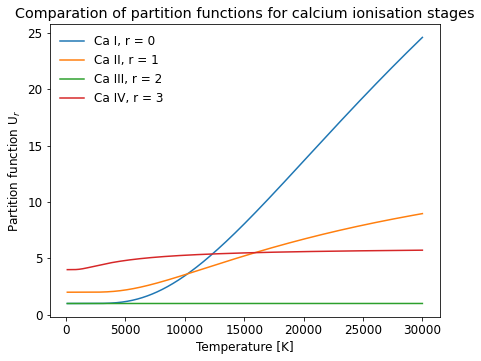

In [6]:
model_Ca = Atom("Ca_atom.txt")

T = numpy.linspace(100, 30000, 1000) * units.K
U_r = model_Ca.compute_partition_function(T)

for stage, tag in enumerate(["I", "II", "III", "IV"]): #four first ionisation stages
    plt.plot(T, U_r[stage], label="Ca "+tag+", r = "+str(stage))
plt.xlabel("Temperature [K]")
plt.ylabel("Partition function U$_r$")
plt.title("Comparation of partition functions for calcium ionisation stages")
plt.legend()
plt.show()

The temperature dependance changes for each $U_r$. Within the specified range, Ca III and Ca IV quickly reach a constant value. Ca II grows, but seems to lessen in velocity for higher T and will eventually stop. Meanwhile Ca I seems to grow linearly after $T \approx 10000$ kelvin, with no sign of stopping or lessening in velocity.

<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">

* Plot a "Payne curve" for the simplified Ca atom using a temperature range of 100 - 175,000 K. Start with $P_e$ = 100 Pa and study how $P_e$ affects the diagram. What is going on?
</div>

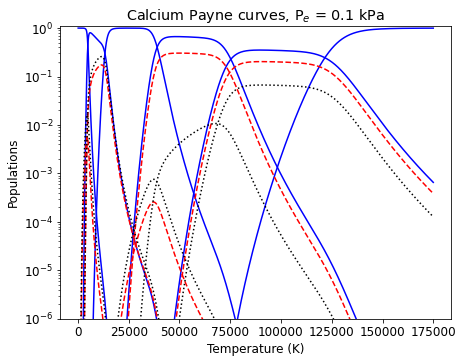

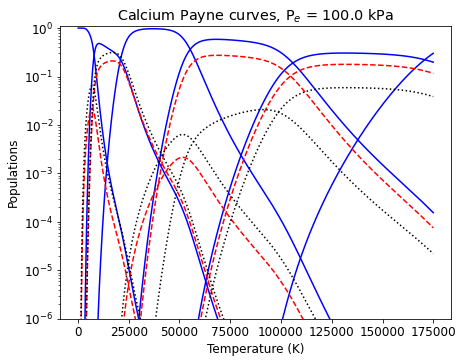

In [7]:
model_Ca = Atom("Ca_atom.txt")
T = numpy.linspace(100, 175000, 1000) * units.K
P_e_list = numpy.array([100, 100000]) * units.Pa
for P_e in P_e_list:
    model_Ca.plot_payne(T, P_e)
    plt.title("Calcium Payne curves, P$_e$ = {}".format(P_e.to("kPa")))

Increasing the electron pressure seems to "widen" the curves and increase the relative strength of excited states (striped lines). Looking at the pressure-density relation $P_e = N_e k T$, we see that increasing pressure while keeping temperature constant will make the density $N_e$ higher to compensate. This will make it harder for atoms to ionise, making lower ionisation stages more prevalent at the same temperature compared to lower pressure. All in all this will cause the "widening" of curves seen in the plots, since the atoms will require higher temperature and energy to ionise.

<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">

* Make a separate figure with a Payne curve for an element of your choice. You can choose one of the existing model atoms, or you can use the [NIST atomic spectra database](https://physics.nist.gov/PhysRefData/ASD/levels_form.html) to build a model for any atom you'd like. How does it compare with Ca?
</div>

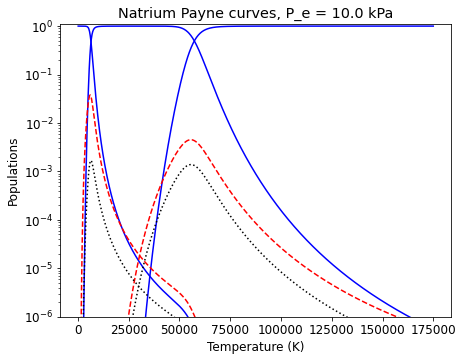

In [8]:
model_Na = Atom("Na_atom.txt")
T = numpy.linspace(100, 175000, 1000) * units.K
P_e = 10000 * units.Pa
model_Na.plot_payne(T, P_e)
plt.title("Natrium Payne curves, P_e = {:.1f}".format(P_e.to("kPa")));

The model looks similar overall to the calcium model, but there are noticeably fewer curves. This is since each curve represents an ionisation level, the number of which is tied to the electron configuration of each element. Also notable is that the natrium model nearly always has a single dominant population, whereas it is somewhat shared for calcium.

## Exercise 3: Solar Ca$^+$K versus H$\alpha$

<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">

* Explain qualitatively why the solar Ca$^+$ K line is much stronger than the solar H$\alpha$ line, even though hydrogen is not ionised in the solar photosphere and low chromosphere ($T \approx$ 4000 - 6000 K) where these lines are formed, and calcium is far less abundant than hydrogen in the Sun: the Ca/H abundance ratio is only $N_\mathrm{Ca}/N_\mathrm{H} = 2 \times 10^{−6}$. Assume again that the observed line strength scales with the lower-level population density (which it does, although nonlinearly through a "curve of growth" as you will see in Project 2).
</div>

The line strengths scale with the lower level populations of the transitions. While the lower level of the Ca$^+$ K line is the ground state, the H$\alpha$ baseline is an excited state. The population of hydrogen at $n=2$ is a factor $2 \cdot 10^{-10}$ lower compared to the ground state hydrogen population. Therefore, despite only having an abundance of $2 \cdot 10^{-6}$ compared to hydrogen, the base level calcium still has a much larger population than $r=0, n=2$ hydrogen.

<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">

* Prove your explanation by computing and plotting the expected strength ratio of these two lines as function of temperature for $P_e = 10^2$ dyne cm$^{-2}$. Make use of `H_atom.txt` and `Ca_atom.txt`.
</div>

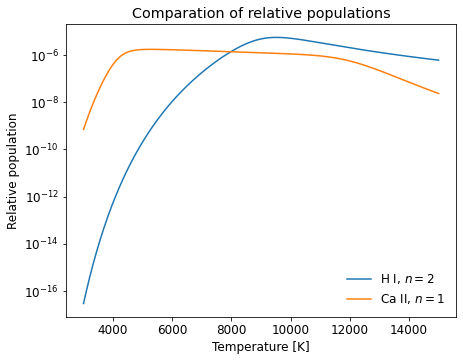

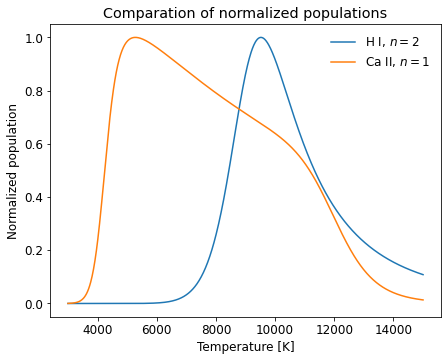

In [9]:
model_H = Atom("H_atom.txt")
model_Ca = Atom("Ca_atom.txt")

T = numpy.linspace(3000, 15000, 1000) * units.K
P_e = 10**2 * units.dyn * units.cm**-2 #units of dyne/cm^2

rel_ab = 2 * 10**-6 #amount of Ca compared to H

HI_2 = model_H.compute_populations(T, P_e)[0, 1] #[0, 1] <=> r=1, s=2
CaII_1_relH = model_Ca.compute_populations(T, P_e)[1, 0] * rel_ab #scaled with hydrogen abundance

plt.plot(T, HI_2, label=r"H I, $n=2$")
plt.plot(T, CaII_1_relH, label=r"Ca II, $n=1$")
plt.title("Comparation of relative populations")
plt.yscale('log')
plt.xlabel("Temperature [K]")
plt.ylabel("Relative population")
plt.legend()
plt.show()

plt.plot(T, HI_2 / max(HI_2), label=r"H I, $n=2$")
plt.plot(T, CaII_1_relH / max(CaII_1_relH), label=r"Ca II, $n=1$")
plt.title("Comparation of normalized populations")
plt.xlabel("Temperature [K]")
plt.ylabel("Normalized population")
plt.legend()
plt.show()

In the plot with relative populations we see that for the low chromosphere $T \approx$ 4000 - 6000 K, the population of $n=2$ H I is much lower than $n=1$ Ca II.

<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">

* The relative population change $(\Delta n / \Delta T) / n$ is useful to to diagnose the temperature sensitivity of the populations of a given atomic stage. Plot in a log scale the relative population changes for the lower levels of Ca$^+$K and H$\alpha$ vs. temperature, using  $\Delta T=$ 1 K. Around $T=$ 5600 K the Ca$^+$K curve dips down to very  small values; the H$\alpha$ curve does that around $T=$ 9500  K. Thus, at $T \approx$ 5600 K the temperature sensitivity of Ca$^+$K is much smaller than the temperature sensitivity of H$\alpha$. Compare these plots with plots of the populations of the lower levels for the two lines (normalise them to the maximum value of each for easier comparison). You should find that the population plots have a peak and two flanks. Explain each flank of the population plots and the dips in the temperature sensitivity plots.
</div>

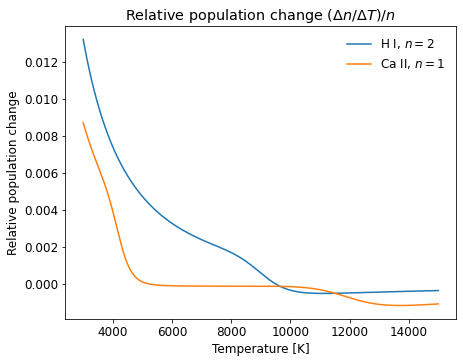

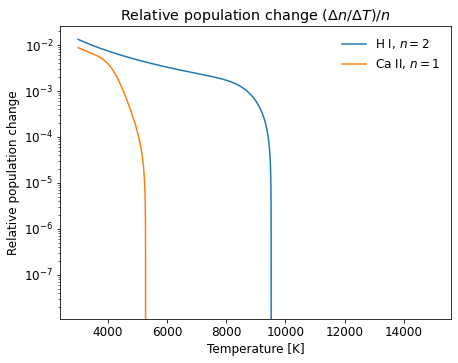

In [10]:
model_H = Atom("H_atom.txt")
model_Ca = Atom("Ca_atom.txt")

T = numpy.arange(3000, 15000, 1) * units.K #dT = 1
P_e = 10**2 * units.dyn * units.cm**-2 #units of dyne/cm^2

rel_ab = 2 * 10**-6 #amount of Ca compared to H

HI_2 = model_H.compute_populations(T, P_e)[0, 1]
CaII_1_relH = model_Ca.compute_populations(T, P_e)[1, 0] * rel_ab

dn_H = numpy.roll(HI_2, -1)[:-1] - HI_2[:-1] #i+1 - i, dropping last point
rel_pop_change_H = dn_H/HI_2[:-1] #(dn/dT)/n, dT = 1

dn_Ca = numpy.roll(CaII_1_relH, -1)[:-1] - CaII_1_relH[:-1]
rel_pop_change_Ca = dn_Ca/CaII_1_relH[:-1]

plt.plot(T[:-1], rel_pop_change_H, label=r"H I, $n=2$")
plt.plot(T[:-1], rel_pop_change_Ca, label=r"Ca II, $n=1$")
plt.title("Relative population change $(\Delta n / \Delta T)/n$")
plt.xlabel("Temperature [K]")
plt.ylabel("Relative population change")
plt.legend()
plt.show()

plt.plot(T[:-1], rel_pop_change_H, label=r"H I, $n=2$")
plt.plot(T[:-1], rel_pop_change_Ca, label=r"Ca II, $n=1$")
plt.title("Relative population change $(\Delta n / \Delta T)/n$")
plt.xlabel("Temperature [K]")
plt.ylabel("Relative population change")
plt.yscale("log")
plt.legend()
plt.show()

The relative change $(\Delta n / \Delta T)/n$ is equivalent with the derivative of the population curves, divided by the values of the original curves. The derivative of a curve is the rate of change, and since the division by n only acts as a scaling factor, we should expect the relative change curve to reflect the rate of change. We can see that this is indeed the case as the case as the points of change in both graphs match at the same temperatures. Most importantly is the maximum of the population curves, as this is where the rate of change crosses zero. This is further highlighted by the logarithmic relative population change, where the curve drops below the reach of the axis, clearly marking the temperatures $T \approx 5600$ K and $T = 9500$ K.

Looking at the plot of normalized populations from the previous task, we can see the two central peaks and flanks as expected. For Ca II $n=1$ the left flank of the population describes how the population increases from Ca I being ionized. The right flank describes the decreasing population both from excitation, since we are looking at the ground level, and ionisation to Ca III. Regarding the H I $n=2$, the increase comes from excitation of H I $n=1$ while the decrease is due to ionisation to H II.

<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">

* Find at which temperature the hydrogen in stellar photospheres with $P_e =$ 10 Pa is about 50% ionised. Plot the neutral and ionised fractions of hydrogen as a function of temperature.
</div>

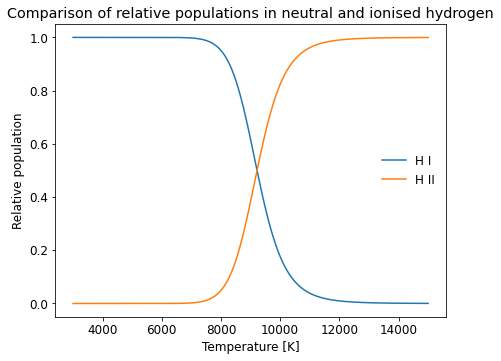

50% ionized at T = 9218.0 K


In [11]:
model_H = Atom("H_atom.txt")

T = numpy.arange(3000, 15000, 1) * units.K #dT = 1
P_e = 10 * units.Pa #same as 100 dyn cm-2

H_pop = model_H.compute_populations(T, P_e)
HI_totpop  = numpy.nansum(H_pop[0], axis=0) #non-ionized population, sum over excited levels
HII_totpop = numpy.nansum(H_pop[1], axis=0) #ionized population

plt.plot(T, HI_totpop, label="H I")
plt.plot(T, HII_totpop, label="H II")
plt.title("Comparison of relative populations in neutral and ionised hydrogen")
plt.xlabel("Temperature [K]")
plt.ylabel("Relative population")
plt.legend()
plt.show()

print("50% ionized at T =", T[numpy.argmin(abs(HI_totpop - HII_totpop))])